# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation
%load_ext memory_profiler

import torch
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("using device: ",device)

using device:  cpu


In [2]:
# render ai gym environment
import gym

env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Environment wrapper
stack two frame together as a state to include temporal information.

In [3]:
from env_wrapper import PongDeterministic
import matplotlib.pyplot as plt

Text(0.5,1,'Processed')

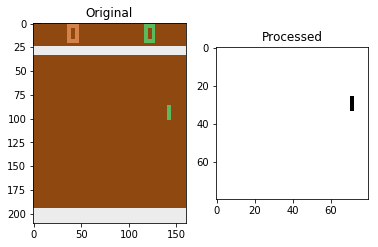

In [4]:
env.reset()
frame, reward, done, info = env.step(env.action_space.sample())
processed = PongDeterministic.preprocess(frame)

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(frame)
axes[0].set_title("Original")

axes[1].imshow(processed, cmap='Greys')
axes[1].set_title("Processed")

In [5]:
env = PongDeterministic()
state, _ = env.reset()
state.shape

(2, 80, 80)

In [6]:
for _ in range(10):
    env.step(env.action_space.sample())

In [7]:
def show_state_frames(state):
    frame1 = state[0, :]
    frame2 = state[1, :]

    fig, axes = plt.subplots(nrows=1, ncols=2)

    axes[0].imshow(frame1, cmap='Greys')
    axes[0].set_title("State - frame 1")

    axes[1].imshow(frame2, cmap='Greys')
    axes[1].set_title("State - frame 2")

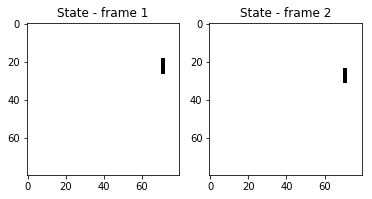

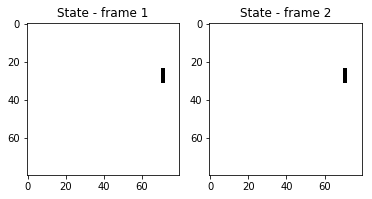

In [8]:
state, reward, done, info, frame = env.step(env.action_space.sample())
show_state_frames(state)
state, reward, done, info, frame = env.step(env.action_space.sample())
show_state_frames(state)

# Game visualization
play game randomly.

In [9]:
from env_wrapper import PongDeterministic
env = PongDeterministic()

In [10]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
    
    def act(self, state):
        prob = 0.5
        return self.env.action_space.sample(), prob

In [11]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)

    fanim = animation.FuncAnimation(plt.gcf(), \
                                    lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)

    display(display_animation(fanim, default_mode='once'))

def play(env, agent, t_max=1000):
    state, frame = env.reset()
    anim_frames = []
    score = 0
    for _ in range(t_max):
        action, prob = agent.act(state)
        next_state, reward, done, _, frame = env.step(action)
        state = next_state
        
        anim_frames.append(frame)
        score += reward
        if done:
            break

    env.close()

    animate_frames(anim_frames)
    return score

In [12]:
# agent = RandomAgent(env)
# score = play(env=env, agent=agent, t_max=1000)
# print(f"score: {score}")

# PPO
you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [13]:
from env_wrapper import PongDeterministic
from model import Actor, Critic
from ppo_agent import Agent
from train import train, plot_scores
from task import ParallelTask

In [14]:
def create_env():
    return PongDeterministic()
envs = ParallelTask(create_env=create_env, n_tasks=8)

env = create_env()
action_dim = env.action_space.n
seed = 0

def create_actor():
    return Actor(action_dim=action_dim, seed=seed)

def create_critic():
    return Critic(seed=seed)

optimization_epochs = 4
discount = 0.95
epsilon = 0.1
entropy_weight = 0.01
learning_rate = 1e-4

agent = Agent(
    create_actor=create_actor,
    create_critic=create_critic,
    num_parallels=envs.size,
    optimization_epochs=optimization_epochs,
    discount=discount,
    epsilon=epsilon,
    entropy_weight=entropy_weight,
    lr=learning_rate,
    device='cpu',
    seed=seed)

In [ ]:
train(envs=envs, agent=agent, max_t=1000)

Episode 49/5000            Score: [-19. -17. -21. -17. -19. -20. -18. -14.]            Average Score: -17.57            Max Score: -15.38            Average steps: 795.24

Episode 50/5000            Score: [-18. -20. -21. -16. -18. -20. -17. -20.]            Average Score: -17.59            Max Score: -15.38            Average steps: 795.00
Episode 99/5000            Score: [-17. -14. -20. -18. -13.  -9. -20. -17.]            Average Score: -17.33            Max Score: -14.12            Average steps: 804.18

Episode 100/5000            Score: [-15.  -9. -16. -21. -17. -15. -19. -10.]            Average Score: -17.31            Max Score: -14.12            Average steps: 805.13
Episode 149/5000            Score: [-10. -11. -10. -15. -19. -11.  -9. -15.]            Average Score: -15.59            Max Score: -11.25            Average steps: 897.91

Episode 150/5000            Score: [-11. -15. -15. -11. -13. -12.  -8. -13.]            Average Score: -15.53            Max Score: -11.25            Average steps: 900.08
Episode 199/5000            Score: [-10.  -8. -12.  -8.  -8. -11. -19.  -9.]            Average Score: -12.75            Max Score: -8.25            Average steps: 990.336

Episode 200/5000            Score: [-13.  -8. -11.  -9. -10. -10.  -8. -14.]            Average Score: -12.71            Max Score: -8.25            Average steps: 991.34
Episode 249/5000            Score: [ -9. -13.  -9. -15. -14. -14.  -5.  -6.]            Average Score: -11.34            Max Score: -8.25            Average steps: 998.89

Episode 250/5000            Score: [-10. -13. -12. -12. -13.  -9. -15. -11.]            Average Score: -11.33            Max Score: -8.25            Average steps: 998.89
Episode 252/5000            Score: [-13. -10. -11.  -6. -12. -12.  -9. -12.]            Average Score: -11.29            Max Score: -8.25            Average steps: 999.47

In [ ]:
plot_scores(scores)

# Watch Smart Agent

In [ ]:
agent = Agent(
    create_actor=create_actor,
    create_critic=create_critic,
    num_parallels=envs.size,
    optimization_epochs=optimization_epochs,
    discount=discount,
    epsilon=epsilon,
    entropy_weight=entropy_weight,
    lr=learning_rate,
    device='cpu',
    seed=seed)

In [ ]:
env = PongDeterministic()

In [ ]:
agent.actor.load_state_dict(torch.load(f"checkpoint_actor.pth"))
agent.critic.load_state_dict(torch.load(f"checkpoint_critic.pth"))

In [ ]:
score = play(env=env, agent=agent, t_max=1000)
print(f"score: {score}")